# Milstones Project 2 : SkimLit 
The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using is availabe here:https://arxiv.org/abs/1710.06071


## Confirm access to GPU

In [1]:
! nvidia-smi


Wed Sep 13 10:40:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P5              10W /  35W |    512MiB /  4096MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get the data 

Since we'll be replicating the paper above (PubMed 200k RCT), let's download dataset they used 

we can do so from authors github:https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!ls Data/pubmed-rct
!ls Data/pubmed-rct/PubMed_20k_RCT/
!ls Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [3]:
# Start our exprimnet using the 20k datasets with numbers replaced '@'
import os 
data_dir = "./Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['./Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 './Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 './Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [4]:
def Get_lines(filename):
    """Reads filename (a text filename) and returns the lines of text as a list.
    Args:
    
    filename: a string containing the target filepath.
    
    Returns:
    A list of strings with one string per line from target filename.
    """
    with open(filename, "r") as f :
        return f.readlines() 

In [5]:
lines = Get_lines(filenames[0])
lines

In [6]:
labels = [line.split("\t")[0] for line in lines]
len(labels) , labels

(210040,
 ['###24293578\n',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  '\n',
  '###24854809\n',
  'BACKGROUND',
  'BACKGROUND',
  'OBJECTIVE',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  '\n',
  '###25165090\n',
  'BACKGROUND',
  'BACKGROUND',
  'METHODS',
  'METHODS',
  'METHODS',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'BACKGROUND',
  '\n',
  '###24633056\n',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'BACKGROUND',
  'BACKGROUND',
  'BACKGROUND',
  'BACKGROUND',
  '\n',
  '###24814304\n',
  'OBJECTIVE',
  'OBJECTIVE',
  'OBJECTIVE',
  'OBJECTIVE',
  'METHODS',
  'ME

In [7]:
text = [line.split("\t")[1] for line in lines if len(line.split("\t")) == 2]
len(text) , text[:5]

(180040,
 ['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n'])

## Content of our data


Let's think about how our data to look...

How I think our data wuld  be best represented ...

`line_number` with `total_lines` show the position the line in our text .

```
[{'line_number' : 0,
    'target' : 'BACKGROUND',
    'text' : '....',
    'total_lines' : 11},
    ...]
```



In [5]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.
    
    Takes in filename , reads it contents and stores through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number the target line is.
    """
    input_lines = Get_lines(filename)
    abstract_line = "" # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstracts
    
    # Loop through each line in the target file 
    for line in input_lines:
        if line.startswith('###'): # check to see if the line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if thee line is an ID line 
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            
            # Iterate through each line in a single abstract and count them at the same time 
            for abstract_line_number , abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for eacj line 
                target_text_split = abstract_line.split("\t") # Split target label from text 
                line_data["target"] = target_text_split[0] # get target label 
                line_data["text"] = target_text_split[1].lower() # get target text
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
                line_data["total_line"] = len(abstract_line_split) - 1 # total lines
                abstract_samples.append(line_data) # add line data to abstract samples list
                
                    
        else: # if the above conditions aren't fullfilled , the line contains a labelles sentence
            abstract_lines += line
    
    return abstract_samples 
            
            

In [7]:
# Get data from file preprocess it

train_samples = preprocess_text_with_line_numbers(filenames[0]) # train_path
val_samples = preprocess_text_with_line_numbers(filenames[2]) # val_path
test_samples = preprocess_text_with_line_numbers(filenames[1]) # test_path
print(len(train_samples),len(test_samples),len(test_samples))

180040 30135 30135


In [8]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# distribuation of labels in training data
train_df.value_counts(subset="target",normalize=True)

target
METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: proportion, dtype: float64

<Axes: ylabel='Frequency'>

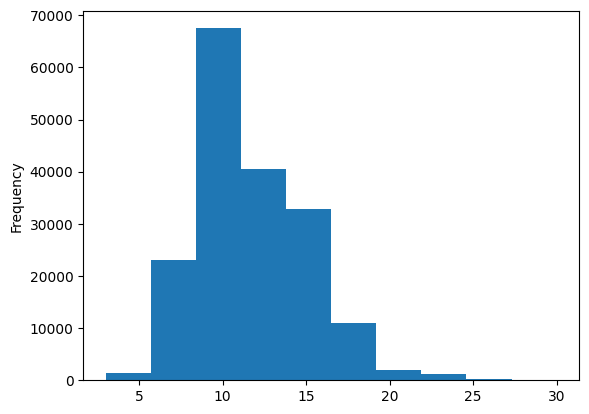

In [9]:
# Let's check the lenght of diffrent lines 
train_df.total_line.plot.hist()

as you can see our data is balanced ...

### Get the lists of sentences

In [10]:
# Conver abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences) , len(val_sentences) , len(test_sentences)

(180040, 30212, 30135)

In [11]:
# view the 10 lines of trianing sentence
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels  (Ml models required numeric labels)

In [12]:
import numpy as np

In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False) # Set sparse to flase because tensorflow cant work with sparse matrix
encoder.fit(np.reshape(train_df.target,(-1,1)))
train_labels_one_hot = encoder.transform(np.reshape(train_df.target,(-1,1)))
val_labels_one_hot = encoder.transform(np.reshape(val_df.target,(-1,1)))
test_labels_one_hot = encoder.transform(np.expand_dims(test_df.target,-1))
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [15]:
class_names = encoder.categories_
class_names

[array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object)]

## Label encoder labels

In [16]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(train_df.target)
train_labels_encode = encoder.transform(train_df.target)
test_labels_encode = encoder.transform(test_df.target)
val_labels_encode = encoder.transform(val_df.target)
np.reshape(train_labels_encode,(-1,1))

array([[3],
       [2],
       [2],
       ...,
       [4],
       [1],
       [1]])

we use this labels to validate our data ...


In [20]:
pd.DataFrame(np.c_[train_df , np.reshape(train_labels_encode,(-1,1))],columns=list(train_df.columns)+["Traget_encode",])

,target,text,line_number,total_line,Traget_encode
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,3
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,2
2,METHODS,outcome measures included pain reduction and i...,2,11,2
3,METHODS,pain was assessed using the visual analog pain...,3,11,2
4,METHODS,secondary outcome measures included the wester...,4,11,2
...,...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11,4
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11,4
180037,RESULTS,both strategies had acceptable side effect pro...,9,11,4
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11,1


## Starting a series of modelling expriments...

As usual,we're going to be trying out a bunch of diffrent models and seeing which one works best.

we're going to start with baseline (TF_IDF Multinomial Naive Bayes classifier).

## Model 0 : BaseLine

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipline 

model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

# Fit the pipline to the training data

model_0.fit(X=train_sentences,
           y=train_labels_encode)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                y=val_labels_encode)

0.7218323844829869

In [23]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
from helper_functions import calculate_results

2023-09-13 10:55:53.236722: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-13 10:55:53.653283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# Calcualte baseline results
baseline_results = calculate_results(y_true=val_labels_encode,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Text(50.72222222222221, 0.5, 'True Label')

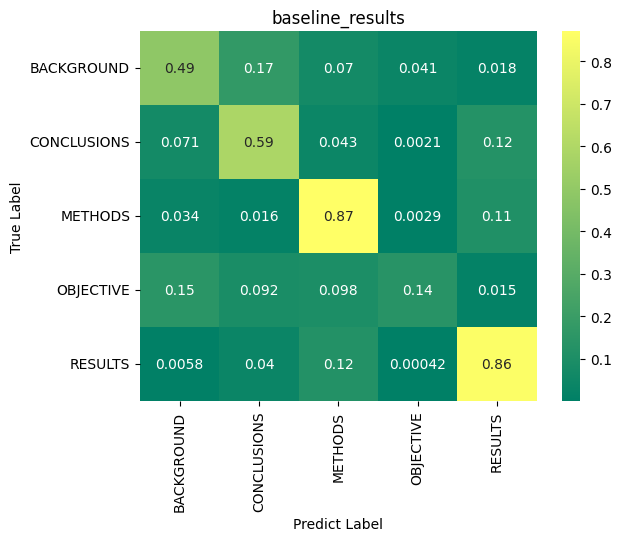

In [26]:
import seaborn as sb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(val_labels_encode,baseline_preds)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm,annot=True,cmap="summer",xticklabels=class_names[0],yticklabels=class_names[0])
plt.title("baseline_results")
plt.xlabel("Predict Label")
plt.ylabel("True Label")

## Preparing our data (the text) for deep sequence models
Before we start building deeper models, we've got to create vectorization and embedding layers.

In [27]:
# How long is each sentence on average ?
train_df["length_txt"] = train_df.text.map(lambda x : len(x.split()))
train_df

,target,text,line_number,total_line,length_txt
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,49
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,27
2,METHODS,outcome measures included pain reduction and i...,2,11,15
3,METHODS,pain was assessed using the visual analog pain...,3,11,14
4,METHODS,secondary outcome measures included the wester...,4,11,35
...,...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11,95
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11,28
180037,RESULTS,both strategies had acceptable side effect pro...,9,11,18
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11,30


In [29]:
train_df.text[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

<Axes: ylabel='Frequency'>

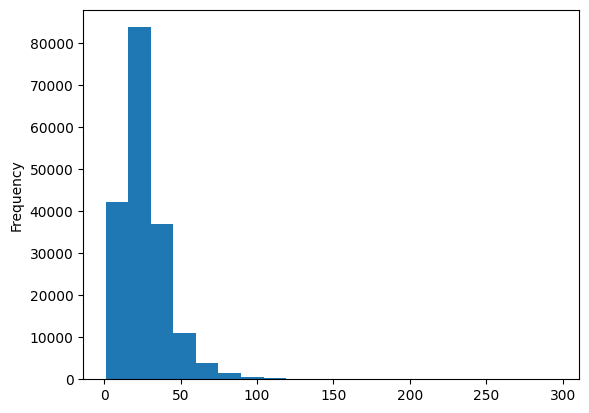

In [30]:
train_df.length_txt.plot(kind="hist",bins=20)

In [31]:
# What is the average of length of sentences?
np.average(train_df.length_txt)

26.338269273494777

In [29]:
# How long of a sentence lenght covers 95% of examples ?
output_seq_len = int(np.percentile(train_df.length_txt,95))
output_seq_len

55

In [30]:
# Maximum sequence lenght in the training set
max(train_df.length_txt)

296

>diffrence between 296 (the maximmum lenght) and the 55 (the number that cover 95% lenght of sentence) is 241 ,so if we choose 296 to cover all sentence lenght ,for 95% of sentence we have average of 241 addition zeros so we choose 55 to avoid this ...

## Create text vectorizer layer 
we want to make a layer which maps our texts from words to numbers.

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers 


In [32]:
max_vocab = 68000 # This number offer by the paper
max_sequence = 55
text_vec = layers.TextVectorization(max_tokens=max_vocab,
                        output_sequence_length=max_sequence)


2023-09-13 10:58:57.674743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 10:58:57.710873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-13 10:58:57.711063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [33]:
# Adapt text vectorizer to training sentence 
text_vec.adapt(train_sentences)

In [34]:
# Test out test vectorizer on random sentence
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLenght of text:{len(target_sentence.split())}")
print(f"\nVectorizer text: {text_vec([target_sentence])}")

Text:
in the european-american ( ea ) subsample ( n = @ ) , rs@ moderated the treatment effect on heavy drinking .

Lenght of text:22

Vectorizer text: [[    5     2 26614  1699  6338    40  1464  4819     2    19    70    18
   2323   871     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
text_vec.get_vocabulary()[-20:]

['abandon',
 'abaloparatideinduced',
 'abagovomabinduced',
 'abacus',
 'abacopd',
 'abacavirlamivudinezidovudine',
 'ababa',
 'aavsercaa',
 'aats',
 'aartselaar',
 'aarm',
 'aaqol',
 'aaq',
 'aanhui',
 'aana',
 'aainduced',
 'aaigroup',
 'aachener',
 'aachen',
 'aaacp']

In [38]:
 # Get the config of our text vectorizer
text_vec.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

 ### Create custiom text embedding
    

In [40]:
embedding = layers.Embedding(max_vocab,
                             128,
                            mask_zero=True,# use masking to handle variable sequence lenghts (save space when your data has many zeros),
                            name="token_embedding") 

In [41]:
# Show example embedding 
print(f"Sentence before vectorization:\n { target_sentence}\n")
vectorized_sentence = text_vec([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedding_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedding_sentence}")
print(f"Embedding sentence shape: {embedding_sentence.shape}")

Sentence before vectorization:
 in the european-american ( ea ) subsample ( n = @ ) , rs@ moderated the treatment effect on heavy drinking .

Sentence after vectorization (before embedding):
 [[    5     2 26614  1699  6338    40  1464  4819     2    19    70    18
   2323   871     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.0430571  -0.0123631  -0.04412    ... -0.02009478  0.033579
    0.03279331]
  [ 0.00463754  0.00723977 -0.03267338 ...  0.03864864 -0.02384702
    0.00046213]
  [ 0.02899735 -0.01353933  0.03167716 ...  0.01023533 -0.03027626
   -0.02115687]
  ...
  [ 0.01500714 -0.00807691 -0.04952791 ... -0.0493967   0.01629012
   -0.02491647]
  [ 0.01500714 -0.00807691 -0.04952791 ... -0.0493967   0.01629012
   -0.02491647]
  [ 0.01500714 -0.00

## Creating datasets (making sure our data loads as fast as possible )

In [42]:
train_df

,target,text,line_number,total_line,length_txt
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,49
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,27
2,METHODS,outcome measures included pain reduction and i...,2,11,15
3,METHODS,pain was assessed using the visual analog pain...,3,11,14
4,METHODS,secondary outcome measures included the wester...,4,11,35
...,...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11,95
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11,28
180037,RESULTS,both strategies had acceptable side effect pro...,9,11,18
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11,30


In [43]:
# Turn our data into tensorflow Datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>




Because we want our model to learn the order of sentences we dont use shuffle.

In [44]:
# Take the TensorsliceDatasets's and turn them into prefected dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [45]:
def make_model_callback(filepath,model_name):
    path = os.path.join(filepath,model_name) +"/"
    return tf.keras.callbacks.ModelCheckpoint(path,
                                        save_best_only=True,
                                       save_weights_only=True)

## Model 1 : Conv1D with token embeddings

In [46]:
num_class = len(train_df.target.value_counts())
num_class


5

In [47]:
# create 1D conv model to process sequences 
import tensorflow as tf
from tensorflow.keras import layers 
inputs_1 = layers.Input(shape=(1,),dtype="string")

x = text_vec(inputs_1)
x = layers.Embedding(input_dim=max_vocab,output_dim=128,name="Embedding_model_1")(x)
x = layers.Conv1D(64,5,padding="same",activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layers

outputs_1 = layers.Dense(num_class,activation="softmax")(x)

model_1 = tf.keras.Model(inputs_1,outputs_1)

# Compile th model 

model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])


In [48]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 Embedding_model_1 (Embeddi  (None, 55, 128)           8704000   
 ng)                                                             
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [49]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.2,
                                                patience=1,
                                                verbose=1,
                                                )

When we first start machine learning project we should train models so fast and examin them very quickly so we train data on only 0.1 percent of train data

because we used prefetch datasets the epochs after first epoch is very fast

In [51]:
hist_csv_file = './SkimLit_weights/model_1/history_1.csv'
if "model_1" not in os.listdir("./SkimLit_weights/"):

    model_1_history = model_1.fit(train_dataset,
           epochs=3,
           validation_data=valid_dataset,
           steps_per_epoch=0.1*len(train_dataset),
           validation_steps=0.1*len(valid_dataset),
           callbacks=[make_model_callback("./SkimLit_weights/","model_1")])

    # Save model_1 history
    hist_df = pd.DataFrame(model_1_history.history)
    
    
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
else:
    model_1.load_weights("./SkimLit_weights/model_1/")
    model_1_history = pd.read_csv(hist_csv_file)

Epoch 1/3
562/562 [==============================] - 4s 8ms/step - loss: 0.5232 - accuracy: 0.8111 - val_loss: 0.6462 - val_accuracy: 0.7645
Epoch 2/3
562/562 [==============================] - 18s 31ms/step - loss: 0.5987 - accuracy: 0.7806 - val_loss: 0.6153 - val_accuracy: 0.7793
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.6004 - accuracy: 0.7834 - val_loss: 0.5895 - val_accuracy: 0.7898


In [52]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.5831 - accuracy: 0.7905


[0.5830919146537781, 0.7905136942863464]

In [53]:
len(valid_dataset) * 32

30240

In [55]:
 # Make predictions (our model prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape ,  model_1_pred_probs[:5]

945/945 [==============================] - 2s 2ms/step


((30212, 5),
 array([[4.8420155e-01, 1.1499556e-01, 8.3302073e-02, 2.8737274e-01,
         3.0128110e-02],
        [4.1600230e-01, 2.4569337e-01, 2.3828942e-02, 2.9785535e-01,
         1.6620029e-02],
        [1.0991002e-01, 3.7003842e-03, 1.4270430e-03, 8.8493240e-01,
         3.0193645e-05],
        [2.1659089e-05, 3.9499844e-04, 9.8589742e-01, 1.4605070e-05,
         1.3671300e-02],
        [7.8597141e-04, 4.6474684e-02, 3.5170501e-01, 4.2267473e-04,
         6.0061163e-01]], dtype=float32))

In [56]:
# Find the predictions class
model_1_pred = model_1_pred_probs.argmax(axis=1)
model_1_pred

array([0, 0, 3, ..., 4, 1, 1])

In [57]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encode,
                                   model_1_pred)
model_1_results

{'accuracy': 79.05137031643056,
 'precision': 0.7873831801349226,
 'recall': 0.7905137031643056,
 'f1': 0.7880915322752866}

Text(50.72222222222221, 0.5, 'True Label')

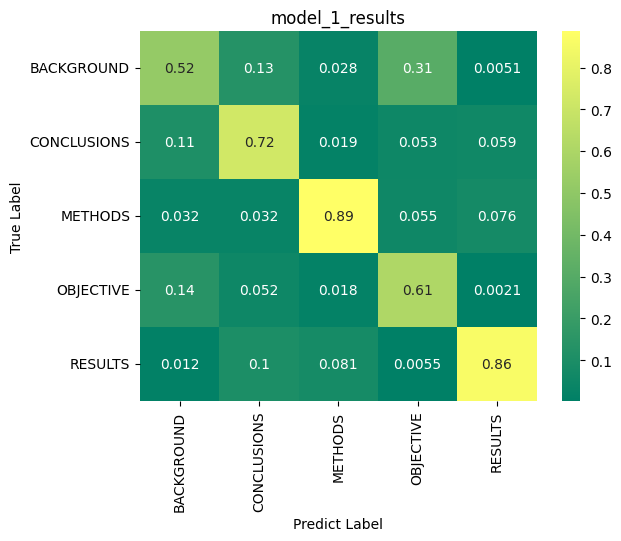

In [58]:
cm = confusion_matrix(val_labels_encode,model_1_pred)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm,annot=True,cmap="summer",xticklabels=class_names[0],yticklabels=class_names[0])
plt.title("model_1_results")
plt.xlabel("Predict Label")
plt.ylabel("True Label")

## Model 2 : Feature extraction with pretrained token embeddings

In [59]:
!pip install tensorflow_hub

In [60]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("./tf_hub/",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [63]:

import random
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding :\n{use_embedded_sentence[0][:20]}\n")
print(f"Lenght of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
in prasugrel group , @ and @ patients were evaluated for ipa at @ hours and day @ respectively whereas in clopdogrel group @ and @ patients were tested for ipa at @ hours and at @ days .
Sentence after embedding :
[ 0.00171715  0.05934547 -0.07527986 -0.00390432  0.06009188 -0.04977824
 -0.01980089 -0.0656869  -0.05010592 -0.03328091  0.07374619  0.01563543
  0.03367317  0.05338305 -0.06618449  0.0656236  -0.07442703 -0.03814403
  0.05126743  0.06398963]

Lenght of sentence embedding: 512


In [64]:
from tensorflow.keras import layers

inputs_2 = layers.Input(shape=[],dtype=tf.string)

x = tf_hub_embedding_layer(inputs_2)

x = layers.Dense(128,activation="relu")(x)

outputs_2 = layers.Dense(num_class,activation="softmax")(x)

model_2 = tf.keras.Model(inputs_2,outputs_2,name="model_2_USE_feture_extractor")

model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [65]:
model_2.summary()

Model: "model_2_USE_feture_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [66]:
hist_csv_file = './SkimLit_weights/model_2/history_2.csv'
if "model_2" not in os.listdir("./SkimLit_weights/"):

    model_2_history = model_2.fit(train_dataset,
                             steps_per_epoch=0.1*len(train_dataset),
                             epochs=3,
                             validation_data=valid_dataset,
                             validation_steps=0.1*len(valid_dataset),
                             callbacks=[make_model_callback("./SkimLit_weights/","model_2")])

    # Save model_2 history
    hist_df = pd.DataFrame(model_2_history.history)
   
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
else:
    model_2.load_weights("./SkimLit_weights/model_2/")
    model_2_history = pd.read_csv(hist_csv_file)

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9101 - accuracy: 0.6520 - val_loss: 0.8016 - val_accuracy: 0.6862
Epoch 2/3
562/562 [==============================] - 15s 27ms/step - loss: 0.7684 - accuracy: 0.7031 - val_loss: 0.7569 - val_accuracy: 0.7033
Epoch 3/3
562/562 [==============================] - 17s 31ms/step - loss: 0.7502 - accuracy: 0.7122 - val_loss: 0.7408 - val_accuracy: 0.7132


In [67]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 19s 19ms/step


array([[0.4489715 , 0.34435225, 0.00194869, 0.19846927, 0.00625823],
       [0.31445503, 0.5349501 , 0.00372495, 0.14477332, 0.0020966 ],
       [0.21320061, 0.13531421, 0.01856639, 0.59186333, 0.04105549],
       ...,
       [0.00217878, 0.00651656, 0.06269106, 0.00108127, 0.9275323 ],
       [0.00455429, 0.04888181, 0.23673832, 0.00187971, 0.7079458 ],
       [0.19842292, 0.24669448, 0.49717742, 0.00849947, 0.04920575]],
      dtype=float32)

In [68]:
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [69]:
model_2_results = calculate_results(y_true=val_labels_encode,
                                   y_pred = model_2_preds)
model_2_results

{'accuracy': 71.6238580696412,
 'precision': 0.7167818461238219,
 'recall': 0.716238580696412,
 'f1': 0.7137065677591764}

Text(50.72222222222221, 0.5, 'True Label')

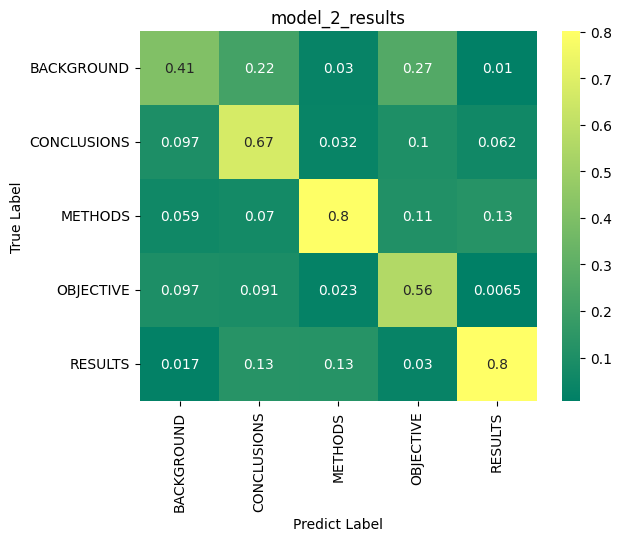

In [70]:
cm = confusion_matrix(val_labels_encode,model_2_preds)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm,annot=True,cmap="summer",xticklabels=class_names[0],yticklabels=class_names[0])
plt.title("model_2_results")
plt.xlabel("Predict Label")
plt.ylabel("True Label")

## Model 3 : Conv1D with character embedding
The paper which we're replicatig states they used a combination of token and character-level embeddings.
Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Create a character-level tokenizer

In [71]:
type(train_sentences[0])," ".join(list(train_sentences[0]))

(str,
 't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .')

In [72]:
# Make functions to split sentences into characters 
def split_chars (text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into character
split_chars(random_train_sentence)


'i n   p r a s u g r e l   g r o u p   ,   @   a n d   @   p a t i e n t s   w e r e   e v a l u a t e d   f o r   i p a   a t   @   h o u r s   a n d   d a y   @   r e s p e c t i v e l y   w h e r e a s   i n   c l o p d o g r e l   g r o u p   @   a n d   @   p a t i e n t s   w e r e   t e s t e d   f o r   i p a   a t   @   h o u r s   a n d   a t   @   d a y s   .'

In [73]:
# Split sequence-level data splits into character-level data split
train_chars = [split_chars(sent) for sent in train_sentences]
val_chars = [split_chars(sent) for sent in val_sentences]
test_chars = [split_chars(sent) for sent in test_sentences]

In [74]:
# What is the average character lenght
char_len = [ len(sent) for sent in train_chars]
mean_char_length = np.mean(char_len)
mean_char_length , len(char_len)

(297.7325149966674, 180040)

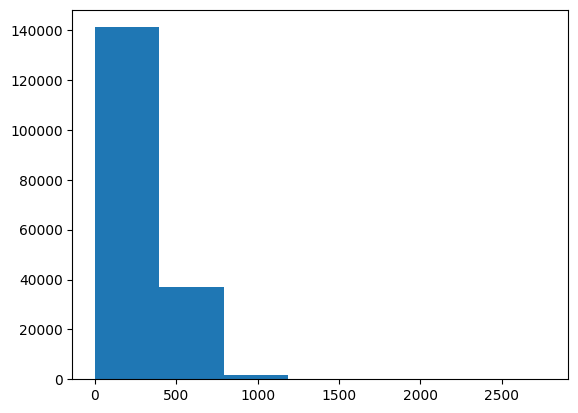

In [75]:
# Check the distributtion of our sequence at a char-level
import matplotlib.pyplot as plt
plt.hist(char_len,bins=7);

In [76]:
# Find what character lenght coveers 95% of sequences
out_seq_char_len = int(np.percentile(char_len,95))
out_seq_char_len

579

In [77]:
# Get all keyboard chcaracters 
import string
alphabet = string.ascii_lowercase + string.digits
alphabet , len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789', 36)

In [79]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = Out Of Vocab,['UNK'])
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                          output_sequence_length = out_seq_char_len,
                                          name="char_vectorizer")

In [80]:
# Adapt character vectorizer to training character 
char_vectorizer.adapt(train_chars)

In [81]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of diffrent characters in character vocab:{len(char_vocab)}")
print(f"5 most common character: {char_vocab[:5]}")
print(f"5 least common character: {char_vocab[-5:]}")

Number of diffrent characters in character vocab:28
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 least common character: ['k', 'x', 'z', 'q', 'j']


In [82]:
# Test out character vectorizer 
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"Lenght of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars:{len(vectorized_chars[0])}")

Charified text:
s a m p l e s   w e r e   r a n d o m l y   d i v i d e d   i n t o   t w o   g r o u p s   (   e a c h   g r o u p   =   @   )   o f   i n t e r v e n t i o n   a n d   c o n t r o l   g r o u p s   .
Lenght of random_train_chars: 201

Vectorized chars:
 [[ 9  5 15 14 12  2  9 20  2  8  2  8  5  6 10  7 15 12 19 10  4 21  4 10
   2 10  4  6  3  7  3 20  7 18  8  7 16 14  9  2  5 11 13 18  8  7 16 14
   7 17  4  6  3  2  8 21  2  6  3  4  7  6  5  6 10 11  7  6  3  8  7 12
  18  8  7 16 14  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [83]:
len(char_vocab)

28

In [84]:
## Creating Embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                            output_dim =24, # This is the size of the char embedding in the paper
                            mask_zero=True)

In [85]:
# Test our  character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer(random_train_chars))
print(f"Embedding chars. (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 s a m p l e s   w e r e   r a n d o m l y   d i v i d e d   i n t o   t w o   g r o u p s   (   e a c h   g r o u p   =   @   )   o f   i n t e r v e n t i o n   a n d   c o n t r o l   g r o u p s   .

Embedding chars. (after vectorization and embedding):
[[ 0.02440179  0.04245246  0.04228796 ...  0.02230145  0.03301754
  -0.01495514]
 [-0.03642773  0.0154034  -0.00982217 ... -0.03590196  0.03275995
  -0.00027211]
 [-0.04560141  0.02581762 -0.04091992 ...  0.00874256  0.00282142
   0.04545308]
 ...
 [ 0.01867468  0.04252997 -0.040836   ...  0.03546889 -0.01169145
   0.0305436 ]
 [ 0.01867468  0.04252997 -0.040836   ...  0.03546889 -0.01169145
   0.0305436 ]
 [ 0.01867468  0.04252997 -0.040836   ...  0.03546889 -0.01169145
   0.0305436 ]]

Character embedding shape: (579, 24)


### Building a Conv1d model to fit on character level embeddings

In [86]:
# Make Conv1D on chars only
inputs_3 = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(inputs_3)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size=10,padding="same",activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs_3 = layers.Dense(num_class,activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs_3,
                        outputs=outputs_3,
                        name="model_3_conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])


In [87]:
# summery
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 579)               0         
 rization)                                                       
                                                                 
 embedding (Embedding)       (None, 579, 24)           672       
                                                                 
 conv1d_1 (Conv1D)           (None, 579, 64)           15424     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [88]:
len(val_sentences)

30212

In [89]:
val_chars[0] , val_labels_one_hot.shape , len(train_chars) , len(train_labels_one_hot)

('i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 (30212, 5),
 180040,
 180040)

In [90]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [91]:
# Fit the model on chars only

hist_csv_file = './SkimLit_weights/model_3/history_3.csv'
if "model_3" not in os.listdir("./SkimLit_weights/"):

    model_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch=0.1 * len(train_char_dataset),
                             validation_data=valid_char_dataset,
                              epochs=3,
                             validation_steps=0.1*len(valid_char_dataset),
                             callbacks=[make_model_callback("./SkimLit_weights/","model_3")])

    # Save model_7 history
    hist_df = pd.DataFrame(model_3_history.history)
    
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
else:
    model_3.load_weights("./SkimLit_weights/model_3/")
    model_3_history = pd.read_csv(hist_csv_file)

Epoch 1/3
562/562 [==============================] - 3s 4ms/step - loss: 1.2217 - accuracy: 0.5045 - val_loss: 0.9951 - val_accuracy: 0.6115
Epoch 2/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9458 - accuracy: 0.6243 - val_loss: 0.8844 - val_accuracy: 0.6579
Epoch 3/3
562/562 [==============================] - 2s 4ms/step - loss: 0.8663 - accuracy: 0.6631 - val_loss: 0.8246 - val_accuracy: 0.6849


In [92]:
# Make predictions with character mdel only 
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 [==============================] - 1s 1ms/step


array([[0.32210243, 0.35560557, 0.11591186, 0.16502303, 0.04135717],
       [0.09791882, 0.5807836 , 0.04090763, 0.1951341 , 0.08525589],
       [0.06858629, 0.19787522, 0.11194506, 0.5790085 , 0.04258494],
       ...,
       [0.00737894, 0.04050792, 0.05573859, 0.01015577, 0.8862187 ],
       [0.03743256, 0.36324537, 0.16332093, 0.06589048, 0.37011066],
       [0.44327322, 0.30698863, 0.06359785, 0.16636558, 0.01977479]],
      dtype=float32)

In [93]:
# Convert predictions probabilities to class labels 
model_3_pred = tf.argmax(model_3_pred_probs,axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [94]:
# Calculate results for Cnv1d model
model_3_results = calculate_results(model_3_pred,
                                  val_labels_encode)
model_3_results

{'accuracy': 67.85714285714286,
 'precision': 0.7156805728248697,
 'recall': 0.6785714285714286,
 'f1': 0.6893930158968339}

Text(50.72222222222221, 0.5, 'True Label')

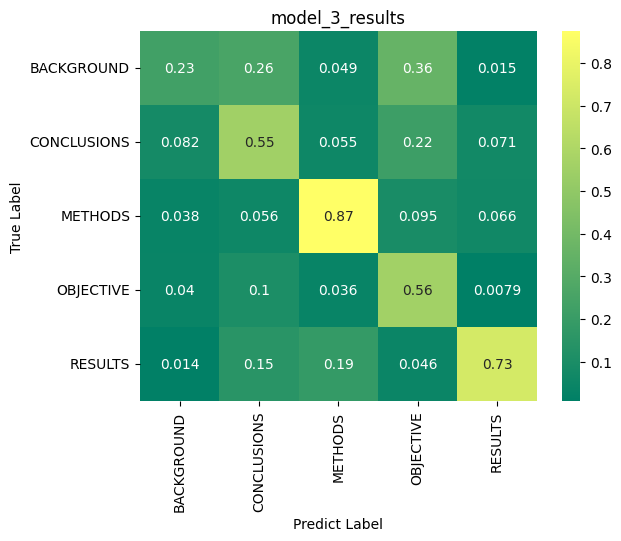

In [95]:
cm = confusion_matrix(val_labels_encode,model_3_pred)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm,annot=True,cmap="summer",xticklabels=class_names[0],yticklabels=class_names[0])
plt.title("model_3_results")
plt.xlabel("Predict Label")
plt.ylabel("True Label")

## Model 4 : Combining pretrained token embeddings + characters embeddings (hybrid)
1. Create a token-level embedding model ( similiar `model_1`)
2. Create a character-level model (similiar to `model_3` with a slight  modification)
3. Combine 1 & 2 with concatenate(`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Paper
5. Construct a model which takes tokens and chareacter-level sequences as inputs and produces sequence label probaabilities as output

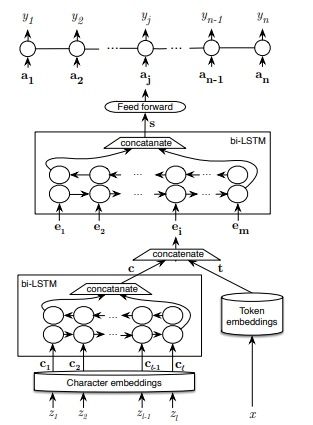

In [96]:
# 1.setup the token inputs/model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="Token_inputs")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(300,activation="relu")(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="Char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding) # Bi-lstm shown in figure
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Concatenate tokken and char inputs (create hyprid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])

# 4. Create output layers - adding in Dropout 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_class,activation="softmax")(final_dropout)

# 5. construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                        outputs=output_layer,
                        name="Model_4_Token_and_char_embedding")

In [97]:
model_4.summary()

Model: "Model_4_Token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 579)                  0         ['Char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978  

In [98]:
from keras.utils import plot_model
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [99]:
# Compile token char model  
model_4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),# section 4.2 of the paper says they use SGD
               metrics=["accuracy"])

### Combining token and character data into a tf.data.Dataset

**NOTE**:*The order of input in train/val_char_token_data is the same as the above where we make our model*
***
model_4 = tf.keras.Model(**inputs=[token_model.input,char_model.input]**,
                        outputs=output_layer,
                        name="Model_4_Token_and_char_embedding")
***

In [100]:
# Combine char and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)# make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data , train_char_token_labels))# Combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [101]:
# Repeat the above steps for our validation data
# Combine char and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)# make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data , val_char_token_labels))# Combine data and labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [102]:
# Checkout our training char and token embedding dataset
train_char_token_dataset , val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting the model on token and characte-level sequences

In [103]:
hist_csv_file = './SkimLit_weights/model_4/history_4.csv'
if "model_4" not in os.listdir("./SkimLit_weights/"):

    model_4_history= model_4.fit(train_char_token_dataset,
                             steps_per_epoch=0.1*len(train_char_token_dataset)
                             ,epochs=3
                             ,validation_data=val_char_token_dataset
                             ,validation_steps=0.1*len(val_char_token_dataset),
               callbacks=[make_model_callback("./SkimLit_weights/","model_4")])

    # Save model_4 history
    hist_df = pd.DataFrame(model_4_history.history)
    
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
else:
    model_4.load_weights("./SkimLit_weights/model_4/")
    model_4_history = pd.read_csv(hist_csv_file)

Epoch 1/3


2023-09-13 11:26:51.839791: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_40/output/_23'


562/562 [==============================] - 17s 22ms/step - loss: 0.9191 - accuracy: 0.6387 - val_loss: 0.7623 - val_accuracy: 0.7023
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7652 - accuracy: 0.7043 - val_loss: 0.6941 - val_accuracy: 0.7296
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7389 - accuracy: 0.7174 - val_loss: 0.6611 - val_accuracy: 0.7487


In [105]:
# Evaluate on whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.6684 - accuracy: 0.7454


[0.6683667302131653, 0.745366096496582]

In [106]:
# make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:6]

945/945 [==============================] - 8s 7ms/step


array([[4.8719266e-01, 2.5929695e-01, 1.6901792e-03, 2.4902171e-01,
        2.7984150e-03],
       [3.5833693e-01, 4.0719727e-01, 2.8453136e-03, 2.3024790e-01,
        1.3725316e-03],
       [2.8874752e-01, 5.8666851e-02, 3.6596756e-02, 5.9651816e-01,
        1.9470699e-02],
       [1.1690761e-02, 2.4127258e-02, 8.5053962e-01, 6.4624110e-03,
        1.0717986e-01],
       [1.4431136e-02, 6.7449853e-02, 7.3259407e-01, 5.7769092e-03,
        1.7974798e-01],
       [6.4137741e-04, 1.2040884e-03, 7.0830458e-01, 2.1159442e-04,
        2.8963834e-01]], dtype=float32)

In [110]:
model_4_pred = model_4_pred_probs.argmax(axis=1)
model_4_pred

array([0, 1, 3, ..., 4, 4, 1])

In [111]:
val_labels_encode

array([0, 0, 3, ..., 4, 1, 1])

In [112]:
model_4_results = calculate_results(model_4_pred,val_labels_encode)
model_4_results

{'accuracy': 74.5366079703429,
 'precision': 0.7572472035121828,
 'recall': 0.745366079703429,
 'f1': 0.7483902461506965}

Text(50.72222222222221, 0.5, 'True Label')

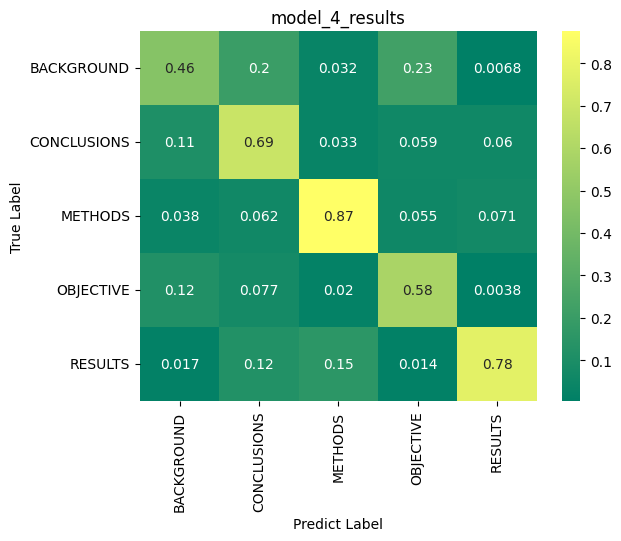

In [113]:
cm = confusion_matrix(val_labels_encode,model_4_pred)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm,annot=True,cmap="summer",xticklabels=class_names[0],yticklabels=class_names[0])
plt.title("model_4_results")
plt.xlabel("Predict Label")
plt.ylabel("True Label")

## Model 5 : Transfer learning with pretrained token embeddings + character embedding + positional embedding

In [114]:
train_df.head()

,target,text,line_number,total_line,length_txt
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,49
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,27
2,METHODS,outcome measures included pain reduction and i...,2,11,15
3,METHODS,pain was assessed using the visual analog pain...,3,11,14
4,METHODS,secondary outcome measures included the wester...,4,11,35


* **NOTE 1** Any engineered features used to train a model need to be available at test time. In our case,line number and total line are availabe.
* **NOTE 2** Data Augmentation is a kind of feature engineering but we usually wont apply Augmentation on test data. 

## Create positioanl embedding 

embedding is a very common word in deep learning . if you transform any type of data into int it's often referred as an embedding.

In [115]:
# How many diffrent line number are there
value_count_line_number = train_df.line_number.value_counts()
value_count_line_number

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

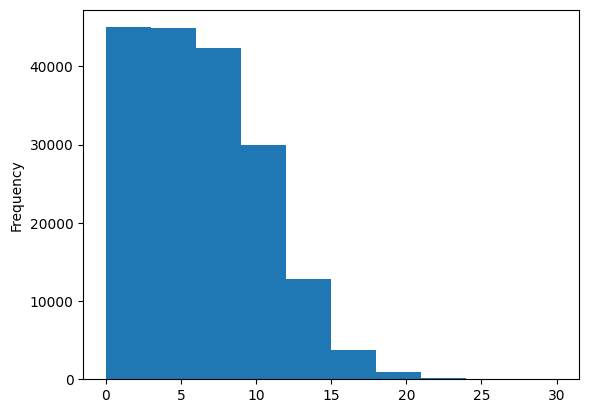

In [116]:
# Check the distribution of "line number" column
train_df.line_number.plot.hist()

In [117]:
np.percentile(train_df.line_number,98)

15.0

In [120]:
np.max(train_df.line_number)

30

In [121]:
# Use tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(),depth=15)
train_line_numbers_one_hot[:10] , train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature . let's do the same for our total lines features ...

In [122]:
# How many diffrent numbers of lines are there ?
train_df.total_line.value_counts().sort_index()

total_line
3        32
4       215
5      1146
6      3353
7      7464
8     12285
9     19400
10    23639
11    24468
12    22113
13    18438
14    14610
15    10768
16     7429
17     5202
18     3344
19     2480
20     1281
21      770
22      759
23      264
24      200
25      182
26       81
27       28
28       58
30       31
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

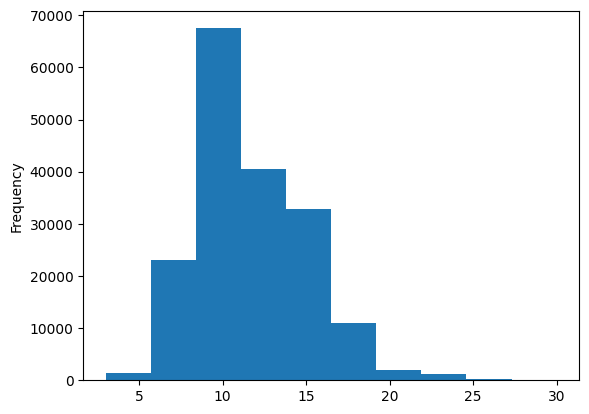

In [123]:
# Check the distributions of total lines 
train_df.total_line.plot.hist()

In [124]:
# Check the coverage of a "total_lines" values of 20
np.percentile(train_df.total_line,98)

20.0

In [125]:
# Use tensorflow to create on-hot-encoded tensors of our "total_lines"feature
train_total_lines_one_hot = tf.one_hot(train_df.total_line.to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_line.to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_line.to_numpy(),depth=20)
train_total_lines_one_hot.shape , train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model 

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_line" feature 
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate and make dense layer on the top of it.
6. Combinethe outputs of 3, 4 using tf.keras.layers.Concatenate and make dense layer on the top of it.
7. concatenate outputs of 5 & 6 and make a dense layer on the top.
8. Create an output layer to accept the tribried embedding and output label probabilities
9. Combine the inputs of 1,2,3,4 and the outputs of 8 into tf.keras.Model

### Create tribrid embedding datasets using tf.data

In [126]:
# Make data set for train data
import tensorflow as tf

train_line_number_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                                        train_chars,
                                                                        train_line_numbers_one_hot,
                                                                        train_total_lines_one_hot))
train_line_number_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_line_number_token_char_dataset = tf.data.Dataset.zip(train_line_number_token_char_data,
                                                           train_line_number_token_char_labels)

# prefetch & set batch size
train_line_number_token_char_dataset = train_line_number_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same steps for validation data

val_line_number_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                                      val_chars,
                                                                      val_line_numbers_one_hot,
                                                                      val_total_lines_one_hot))
val_line_number_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_line_number_token_char_dataset = tf.data.Dataset.zip(val_line_number_token_char_data,
                                                         val_line_number_token_char_labels)

# prefetch & set batch size
val_line_number_token_char_dataset = val_line_number_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Start design architecture

In [127]:
# Setup architecture for tribird

# 1-Make model for token input 

input_token = layers.Input(shape=[],dtype="string")

token_embedding = tf_hub_embedding_layer(input_token)

token_out = layers.Dense(300,activation="relu")(token_embedding)

token_model = tf.keras.Model(input_token,token_out)


# 2-Make model for character embedding input

input_char = layers.Input(shape=(1,),dtype="string")

char_vec_output = char_vectorizer(input_char)

embed_output = layers.Embedding(input_dim=len(char_vocab),
                               output_dim=24,
                               mask_zero=True)(char_vec_output)

char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(embed_output)

char_model = tf.keras.Model(input_char,char_bi_lstm)


# 3-Make model for line number 

input_line = layers.Input(shape=(15,),dtype=tf.float32)

dense_out = layers.Dense(24,activation="relu")(input_line)

line_number_model = tf.keras.Model(input_line,dense_out)


# 4-Make model for total lines 

input_total = layers.Input(shape=(20,),dtype=tf.float32)

dense_out_2 = layers.Dense(24,activation="relu")(input_total)

total_number_model = tf.keras.Model(input_total,dense_out_2)

# 5-Combine 1 & 2 

combine_out_1 = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                              char_model.output])
dense_out_3 = layers.Dense(48,activation="relu")(combine_out_1)

# 6-Combine 3 & 4

combine_out_2 = layers.Concatenate(name="line_total_hybrid")([line_number_model.output,
                                                             total_number_model.output])
dense_out_4 = layers.Dense(48,activation="relu")(combine_out_2)

# 7-Combine 5 & 6

combine_out_3 = layers.Concatenate(name="token_char_number_hybrid")([dense_out_3,
                                                             dense_out_4])

# 8-Drop some values and make output

drop_1 = layers.Dropout(0.4)(combine_out_3)
dense_5 = layers.Dense(200,activation="relu")(drop_1)
drop_2 = layers.Dropout(0.4)(dense_5)
output_final = layers.Dense(num_class,activation="softmax")(drop_2)

# 9-Make model 

model_5 = tf.keras.Model(inputs=[input_token,
                                 input_char,
                                 input_line,
                                 input_total],
                        outputs=output_final)

model_5.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])



In [128]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 579)                  0         ['input_5[0][0]']             
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['input_4[0][0]']       

In [129]:
plot_model(model_5)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [131]:
hist_csv_file = './SkimLit_weights/model_5/history_5.csv'
if "model_5" not in os.listdir("./SkimLit_weights/"):

    model_5_history = model_5.fit(train_line_number_token_char_dataset,
           epochs=3,
           steps_per_epoch=0.1*len(train_line_number_token_char_dataset),
           validation_data=val_line_number_token_char_dataset,
           validation_steps=0.1*len(val_line_number_token_char_dataset),
           callbacks=[make_model_callback("./SkimLit_weights/","model_5")])

    # Save model_5 history
    hist_df = pd.DataFrame(model_5_history.history)
    
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
else:
    model_5.load_weights("./SkimLit_weights/model_5/")
    model_5_history = pd.read_csv(hist_csv_file)

In [132]:
model_5.evaluate(val_line_number_token_char_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.3957 - accuracy: 0.8456


[0.39570608735084534, 0.845591127872467]

In [124]:
model_5_pred_probs = model_5.predict(val_line_number_token_char_dataset)
model_5_pred_probs[:10]

945/945 [==============================] - 8s 7ms/step


array([[5.60425580e-01, 7.83551368e-05, 2.27939472e-05, 4.39467579e-01,
        5.67918914e-06],
       [6.50868416e-01, 2.84360809e-04, 6.05895184e-04, 3.48219812e-01,
        2.15938362e-05],
       [4.41365898e-01, 1.51323318e-03, 6.80810213e-02, 4.78416532e-01,
        1.06232706e-02],
       [8.38894956e-03, 4.58592549e-04, 8.92520547e-01, 4.26546764e-03,
        9.43665057e-02],
       [1.33028673e-02, 1.84691045e-03, 8.76940370e-01, 5.22469217e-03,
        1.02685235e-01],
       [4.62322278e-05, 5.43765433e-04, 6.15022965e-02, 8.42757981e-06,
        9.37899292e-01],
       [1.21293873e-04, 3.74335260e-03, 4.74820994e-02, 2.34909839e-05,
        9.48629797e-01],
       [1.14523966e-04, 8.26538075e-03, 3.03819720e-02, 1.36653161e-05,
        9.61224496e-01],
       [3.38941027e-05, 2.52360646e-02, 4.00921749e-03, 3.74349497e-06,
        9.70717072e-01],
       [4.96087014e-04, 9.84141290e-01, 6.87980908e-04, 4.33820933e-05,
        1.46311987e-02]], dtype=float32)

In [125]:
model_5_preds = model_5_pred_probs.argmax(axis=1)
model_5_preds[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [126]:
model_5_results = calculate_results(val_labels_encode,model_5_preds)
model_5_results

{'accuracy': 84.64517410300543,
 'precision': 0.8464543398372762,
 'recall': 0.8464517410300543,
 'f1': 0.8459902481067415}

In [134]:
train_df

,target,text,line_number,total_line,length_txt
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,49
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,27
2,METHODS,outcome measures included pain reduction and i...,2,11,15
3,METHODS,pain was assessed using the visual analog pain...,3,11,14
4,METHODS,secondary outcome measures included the wester...,4,11,35
...,...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11,95
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11,28
180037,RESULTS,both strategies had acceptable side effect pro...,9,11,18
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11,30


Text(50.72222222222221, 0.5, 'True Label')

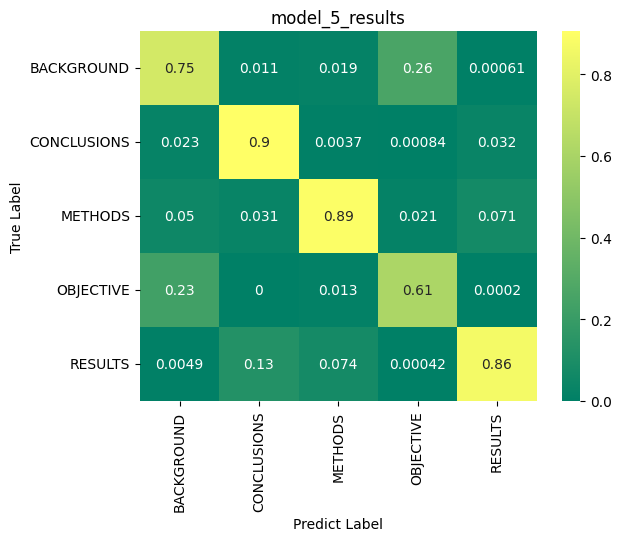

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
cm = confusion_matrix(val_labels_encode,model_5_preds)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm,annot=True,cmap="summer",xticklabels=class_names[0],yticklabels=class_names[0])
plt.title("model_5_results")
plt.xlabel("Predict Label")
plt.ylabel("True Label")

## Model 6 : Using SGD optimizer
Same architecture but insted of Adam using SGD optimizer

In [128]:
# Setup architecture for tribird

# 1-Make model for token input 

input_token = layers.Input(shape=[],dtype="string")

tf_hub_layer = tf_hub_embedding_layer(input_token)

x = layers.Dense(300,activation="relu")(tf_hub_layer)

token_model = tf.keras.Model(input_token,x)


# 2-Make model for character embedding input

input_char = layers.Input(shape=(1,),dtype="string")

char_vec_output = char_vectorizer(input_char)

embed_output = layers.Embedding(input_dim=len(char_vocab),
                               output_dim=24,
                               mask_zero=True)(char_vec_output)

char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(embed_output)

char_model = tf.keras.Model(input_char,char_bi_lstm)


# 3-Make model for line number 

input_line = layers.Input(shape=(15,),dtype=tf.float32)

dense_out = layers.Dense(24,activation="relu")(input_line)

line_number_model = tf.keras.Model(input_line,dense_out)


# 4-Make model for total lines 

input_total = layers.Input(shape=(20,),dtype=tf.float32)

dense_out_2 = layers.Dense(24,activation="relu")(input_total)

total_number_model = tf.keras.Model(input_total,dense_out_2)

# 5-Combine 1 & 2 

combine_out_1 = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                              char_model.output])
dense_out_3 = layers.Dense(48,activation="relu")(combine_out_1)

# 6-Combine 3 & 4

combine_out_2 = layers.Concatenate(name="line_total_hybrid")([line_number_model.output,
                                                             total_number_model.output])
dense_out_4 = layers.Dense(48,activation="relu")(combine_out_2)

# 8-Combine 5 & 6

combine_out_3 = layers.Concatenate(name="token_char_number_hybrid")([dense_out_3,
                                                             dense_out_4])

# 9-Drop some values and make output

drop_1 = layers.Dropout(0.4)(combine_out_3)
dense_5 = layers.Dense(200,activation="relu")(drop_1)
drop_2 = layers.Dropout(0.4)(dense_5)
output_final = layers.Dense(num_class,activation="softmax")(drop_2)

model_6 = tf.keras.Model(inputs=[input_token,
                                 input_char,
                                 input_line,
                                 input_total],
                        outputs=output_final)

model_6.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.SGD(),
               metrics=["accuracy"])



In [129]:
model_6.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 579)                  0         ['input_9[0][0]']             
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['input_8[0][0]']      

In [130]:
plot_model(model_6)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [131]:
hist_csv_file = './SkimLit_weights/model_6/history_6.csv'
if "model_6" not in os.listdir("./SkimLit_weights/"):

    model_6_history = model_6.fit(train_line_number_token_char_dataset,
           epochs=3,
           steps_per_epoch=0.1*len(train_line_number_token_char_dataset),
           validation_data=val_line_number_token_char_dataset,
           validation_steps=0.1*len(val_line_number_token_char_dataset),
           callbacks=[make_model_callback("./SkimLit_weights/","model_6")])

    # Save model_6 history
    hist_df = pd.DataFrame(model_6_history.history)
   
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
else:
    model_6.load_weights("./SkimLit_weights/model_6/")
    model_6_history = pd.read_csv(hist_csv_file)

Epoch 1/3
562/562 [==============================] - 18s 22ms/step - loss: 1.4776 - accuracy: 0.3547 - val_loss: 1.4155 - val_accuracy: 0.4211
Epoch 2/3
562/562 [==============================] - 10s 19ms/step - loss: 1.3782 - accuracy: 0.4296 - val_loss: 1.3049 - val_accuracy: 0.4852
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 1.2547 - accuracy: 0.4768 - val_loss: 1.1387 - val_accuracy: 0.5201


In [132]:
model_6.evaluate(val_line_number_token_char_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 1.1293 - accuracy: 0.5253


[1.1293234825134277, 0.5252879858016968]

In [133]:
model_6_pred_probs = model_6.predict(val_line_number_token_char_dataset)
model_6_pred_probs[:10]

945/945 [==============================] - 8s 7ms/step


array([[0.29717156, 0.1270538 , 0.2062855 , 0.21939342, 0.15009579],
       [0.24036448, 0.15409814, 0.2935758 , 0.14993696, 0.1620246 ],
       [0.20841423, 0.10121271, 0.41302508, 0.15196134, 0.12538669],
       [0.06439123, 0.103559  , 0.58347285, 0.04002521, 0.2085517 ],
       [0.08553209, 0.09992073, 0.56790686, 0.05406599, 0.19257428],
       [0.03078348, 0.10760297, 0.3746146 , 0.02073965, 0.46625933],
       [0.04195703, 0.12288446, 0.31865302, 0.0293878 , 0.4871177 ],
       [0.02954438, 0.13554251, 0.24035913, 0.02081183, 0.57374215],
       [0.03655854, 0.17723316, 0.17226747, 0.02402982, 0.58991104],
       [0.05138635, 0.19656561, 0.17417142, 0.03485572, 0.5430209 ]],
      dtype=float32)

In [134]:
model_6_preds = model_6_pred_probs.argmax(axis=1)
model_6_preds[:10]

array([0, 2, 2, 2, 2, 4, 4, 4, 4, 4])

In [135]:
model_6_results = calculate_results(val_labels_encode,model_6_preds)
model_6_results

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 52.52879650470012,
 'precision': 0.4046530179695046,
 'recall': 0.5252879650470011,
 'f1': 0.4466585954216519}

Text(50.72222222222221, 0.5, 'True Label')

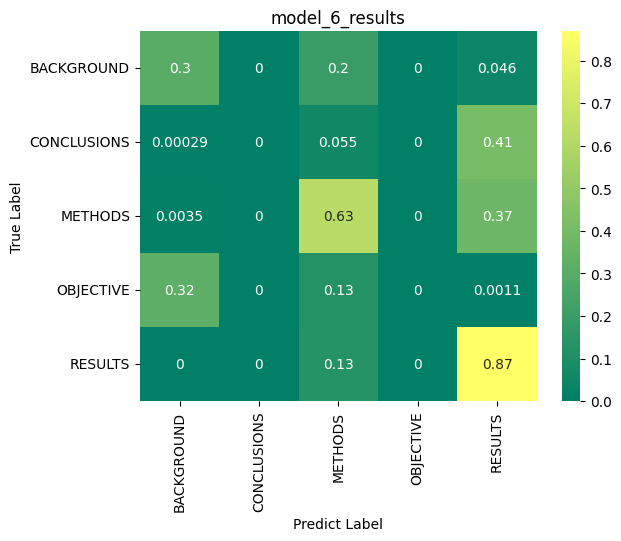

In [136]:
cm = confusion_matrix(val_labels_encode,model_6_preds)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm,annot=True,cmap="summer",xticklabels=class_names[0],yticklabels=class_names[0])
plt.title("model_6_results")
plt.xlabel("Predict Label")
plt.ylabel("True Label")

## Model 7 : Using Label smoothing

In [137]:
# Setup architecture for tribird

# 1-Make model for token input 



input_token = layers.Input(shape=[],dtype="string")

token_embedding = tf_hub_embedding_layer(input_token)

token_out = layers.Dense(300,activation="relu")(token_embedding)

token_model = tf.keras.Model(input_token,token_out)


# 2-Make model for character embedding input

input_char = layers.Input(shape=(1,),dtype="string")

char_vec_output = char_vectorizer(input_char)

embed_output = layers.Embedding(input_dim=len(char_vocab),
                               output_dim=24,
                               mask_zero=True)(char_vec_output)

char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(embed_output)

char_model = tf.keras.Model(input_char,char_bi_lstm)


# 3-Make model for line number 

input_line = layers.Input(shape=(15,),dtype=tf.float32)

dense_out = layers.Dense(24,activation="relu")(input_line)

line_number_model = tf.keras.Model(input_line,dense_out)


# 4-Make model for total lines 

input_total = layers.Input(shape=(20,),dtype=tf.float32)

dense_out_2 = layers.Dense(24,activation="relu")(input_total)

total_number_model = tf.keras.Model(input_total,dense_out_2)

# 5-Combine 1 & 2 

combine_out_1 = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                              char_model.output])
dense_out_3 = layers.Dense(48,activation="relu")(combine_out_1)

# 6-Combine 3 & 4

combine_out_2 = layers.Concatenate(name="line_total_hybrid")([line_number_model.output,
                                                             total_number_model.output])
dense_out_4 = layers.Dense(48,activation="relu")(combine_out_2)

# 7-Combine 5 & 6

combine_out_3 = layers.Concatenate(name="token_char_number_hybrid")([dense_out_3,
                                                             dense_out_4])

# 8-Drop some values and make output

drop_1 = layers.Dropout(0.4)(combine_out_3)
dense_5 = layers.Dense(200,activation="relu")(drop_1)
drop_2 = layers.Dropout(0.4)(dense_5)
output_final = layers.Dense(num_class,activation="softmax")(drop_2)

# 9-Make model 

model_7 = tf.keras.Model(inputs=[input_token,
                                 input_char,
                                 input_line,
                                 input_total],
                        outputs=output_final)

model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])



### What is label smoothing ?

For Example. if our model gets too confident on a single class (e.g its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really Confident: `[0.0,0.0,1.0,0.0,0.0]`

What label smothing does is it assigns some of the value from the highest pred prob to other classes , in turn , hopefully improving generalization: `[0.01,0.01,0.96,0.01,0.01]`

This can prevent overfitting and improve generalization.

In [138]:
model_7.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 579)                  0         ['input_13[0][0]']            
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['input_12[0][0]']     

In [139]:
plot_model(model_7)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [141]:
hist_csv_file = './SkimLit_weights/model_7/history_7.csv'

model_7_history = model_7.fit(train_line_number_token_char_dataset,
           epochs=3,
           steps_per_epoch=0.1*len(train_line_number_token_char_dataset),
           validation_data=val_line_number_token_char_dataset,
           validation_steps=0.1*len(val_line_number_token_char_dataset),
           callbacks=[make_model_callback("./SkimLit_weights/","model_7")])

# Save model_7 history
hist_df = pd.DataFrame(model_7_history.history)


Epoch 1/3
562/562 [==============================] - 19s 24ms/step - loss: 0.9465 - accuracy: 0.7161 - val_loss: 0.7670 - val_accuracy: 0.8089
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7811 - accuracy: 0.8116 - val_loss: 0.7096 - val_accuracy: 0.8408
Epoch 3/3
562/562 [==============================] - 10s 19ms/step - loss: 0.7448 - accuracy: 0.8284 - val_loss: 0.6886 - val_accuracy: 0.8523


In [143]:
model_7.evaluate(val_line_number_token_char_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.6858 - accuracy: 0.8485


[0.6858233213424683, 0.8485038876533508]

In [144]:
model_7_pred_probs = model_7.predict(val_line_number_token_char_dataset)
model_7_pred_probs[:10]

945/945 [==============================] - 9s 7ms/step


array([[0.55845577, 0.01873996, 0.00565788, 0.4069921 , 0.01015423],
       [0.50405604, 0.01293151, 0.01111626, 0.46117577, 0.01072039],
       [0.26545537, 0.02515825, 0.05829164, 0.616272  , 0.03482272],
       [0.01968592, 0.01928366, 0.8600267 , 0.02256807, 0.07843572],
       [0.02865169, 0.02646625, 0.8092248 , 0.02832559, 0.10733159],
       [0.00774041, 0.01581995, 0.13227324, 0.01124156, 0.8329249 ],
       [0.00944849, 0.02053307, 0.09618463, 0.01420078, 0.85963297],
       [0.00798594, 0.03119095, 0.08441851, 0.01115887, 0.86524576],
       [0.01287611, 0.04144376, 0.01778996, 0.01559092, 0.9122993 ],
       [0.0168857 , 0.91964865, 0.01116701, 0.01092864, 0.04137013]],
      dtype=float32)

In [145]:
model_7_preds = model_7_pred_probs.argmax(axis=1)
model_7_preds[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [146]:
model_7_results = calculate_results(val_labels_encode,model_7_preds)
model_7_results

{'accuracy': 84.85039057328214,
 'precision': 0.8478109671053936,
 'recall': 0.8485039057328214,
 'f1': 0.8480044715982273}

Text(50.72222222222221, 0.5, 'True Label')

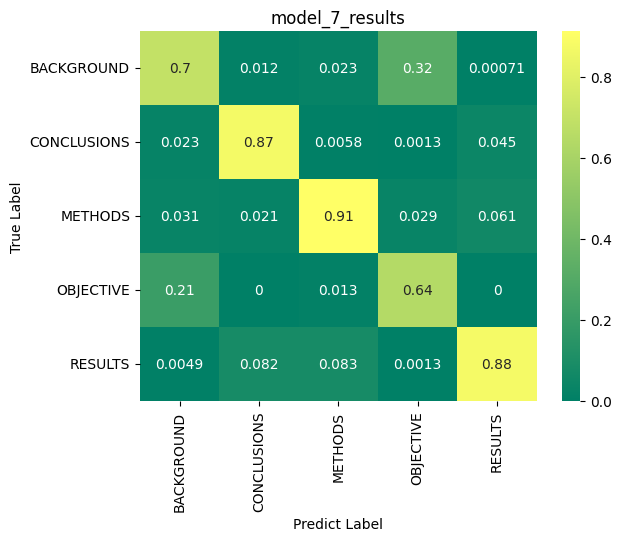

In [147]:
cm = confusion_matrix(val_labels_encode,model_7_preds)
cm = cm / cm.sum(axis=1)
sb.heatmap(cm,annot=True,cmap="summer",xticklabels=class_names[0],yticklabels=class_names[0])
plt.title("model_7_results")
plt.xlabel("Predict Label")
plt.ylabel("True Label")

## Compare model resutls

In [148]:
# Combine model results into a dataframe
import pandas as pd
all_model_results = pd.DataFrame([baseline_results,
                                 model_1_results,
                                 model_2_results,
                                 model_3_results,
                                 model_4_results,
                                 model_5_results,
                                 model_6_results,
                                 model_7_results],index=["baseline_sklearn",
                                                         "Conv1D_with_Token_Embed",
                                                        "Pretrained_Token_Embed_with_Dense_layer",
                                                        "Conv1D_with_Character_Embed",
                                                        "Pretrained_Token + Characters_Embed",
                                                        "Pretrained_Token + Characters + Positional_Embed",
                                                        "Pretrained_Token + Characters + Positional_Embed_with_SGD",
                                                        "Pretrained_Token + Characters + Positional_Embed_with_Label_Smothing"])
all_model_results["accuracy"] = all_model_results["accuracy"] * 0.01

all_model_results

,accuracy,precision,recall,f1
baseline_sklearn,0.721832,0.718647,0.721832,0.698925
Conv1D_with_Token_Embed,0.787038,0.784098,0.787038,0.784447
Pretrained_Token_Embed_with_Dense_layer,0.713855,0.714906,0.713855,0.711193
Conv1D_with_Character_Embed,0.683470,0.715132,0.683470,0.693729
Pretrained_Token + Characters_Embed,0.747683,0.753959,0.747683,0.749550
Pretrained_Token + Characters + Positional_Embed,0.846452,0.846454,0.846452,0.845990
Pretrained_Token + Characters + Positional_Embed_with_SGD,0.525288,0.404653,0.525288,0.446659
Pretrained_Token + Characters + Positional_Embed_with_Label_Smothing,0.848504,0.847811,0.848504,0.848004


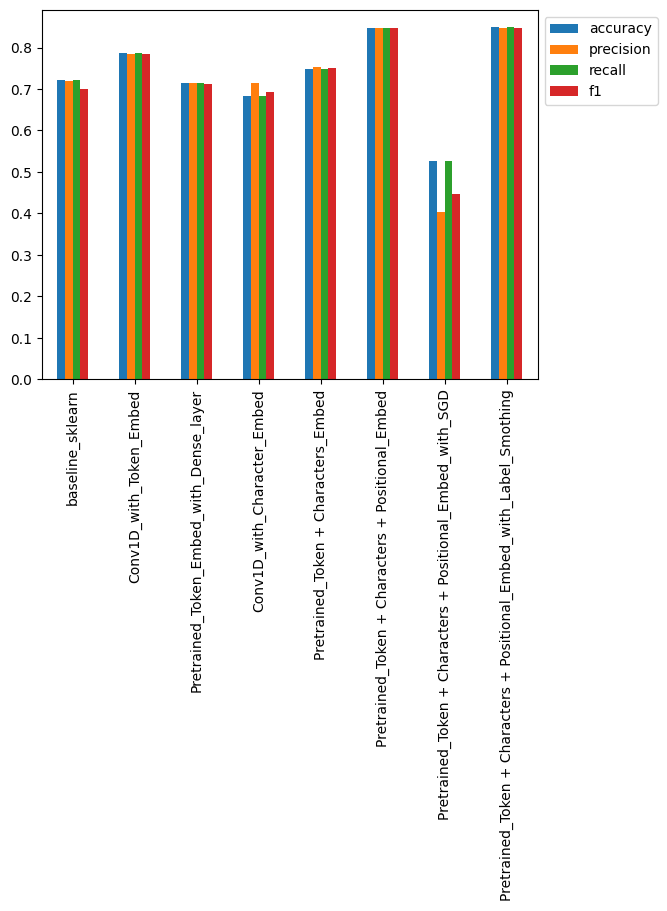

In [149]:
all_model_results.plot.bar().legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

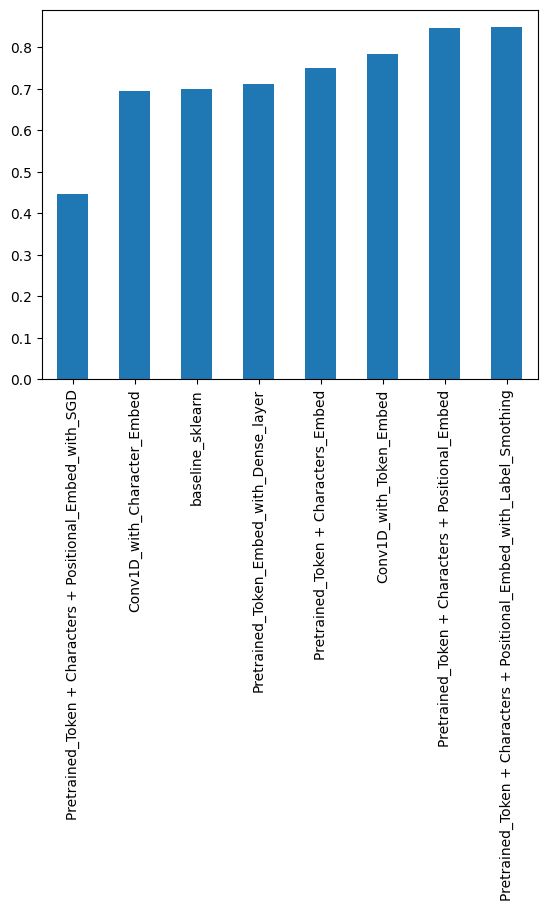

In [150]:
# Sort models by f1 and plot 
all_model_results["f1"].sort_values().plot.bar()

## Find the mistakes that has great confidence for model 7

In [155]:
model_7.evaluate(test_line_number_token_char_dataset)

942/942 [==============================] - 7s 8ms/step - loss: 0.7001 - accuracy: 0.8415


[0.7000515460968018, 0.8415132164955139]

In [156]:
model_7_pred_probs = model_7.predict(test_line_number_token_char_dataset)
model_7_pred_probs[:10]

942/942 [==============================] - 6s 7ms/step


array([[0.40711814, 0.02610803, 0.01440086, 0.5283424 , 0.02403053],
       [0.38500467, 0.02601131, 0.09411936, 0.471811  , 0.02305374],
       [0.01783491, 0.01216707, 0.9064421 , 0.03143461, 0.03212126],
       [0.02444365, 0.02414723, 0.75838685, 0.03247632, 0.16054599],
       [0.02045797, 0.02610715, 0.10045487, 0.02346104, 0.8295189 ],
       [0.01087605, 0.00997592, 0.01338478, 0.01178899, 0.9539742 ],
       [0.01858001, 0.05810238, 0.1720588 , 0.02937224, 0.7218866 ],
       [0.04311398, 0.53727424, 0.12348847, 0.02673634, 0.26938698],
       [0.01574478, 0.76391244, 0.01424627, 0.01399225, 0.19210435],
       [0.5828713 , 0.01142039, 0.00389083, 0.39526895, 0.00654848]],
      dtype=float32)

In [157]:
model_7_preds = model_7_pred_probs.argmax(axis=1)
model_7_preds[:10]

array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])

In [158]:
model_7_pred_probs.max(axis=1)

array([0.5283424 , 0.471811  , 0.9064421 , ..., 0.7217024 , 0.76943934,
       0.59427565], dtype=float32)

In [159]:
True_label_name = [ class_names[0][i]for i in test_labels_encode]
Pred_label_name = [class_names[0][i] for i in model_7_preds]

In [160]:
Evaluate_df = pd.DataFrame({"Test_Sentece":test_sentences,
             "True_Label":test_labels_encode,
             "True_Label_name":True_label_name,
             "Pred_Label":model_7_preds,
             "Pred_Label_name":Pred_label_name,
             "Pred_prob":model_7_pred_probs.max(axis=1)})
Evaluate_df

,Test_Sentece,True_Label,True_Label_name,Pred_Label,Pred_Label_name,Pred_prob
0,this study analyzed liver function abnormaliti...,0,BACKGROUND,3,OBJECTIVE,0.528342
1,a post hoc analysis was conducted with the use...,4,RESULTS,3,OBJECTIVE,0.471811
2,liver function tests ( lfts ) were measured at...,4,RESULTS,2,METHODS,0.906442
3,survival analyses were used to assess the asso...,4,RESULTS,2,METHODS,0.758387
4,the percentage of patients with abnormal lfts ...,4,RESULTS,4,RESULTS,0.829519
...,...,...,...,...,...,...
30130,there was a statistically significant between-...,4,RESULTS,4,RESULTS,0.923536
30131,there were no statistically significant betwee...,4,RESULTS,4,RESULTS,0.798615
30132,there was no significant association between s...,4,RESULTS,4,RESULTS,0.721702
30133,no adverse effects were reported .,4,RESULTS,4,RESULTS,0.769439


In [161]:
Wrong_df = Evaluate_df[Evaluate_df.True_Label != Evaluate_df.Pred_Label].sort_values(by="Pred_prob",ascending=False).reset_index(drop=True)
Wrong_df

,Test_Sentece,True_Label,True_Label_name,Pred_Label,Pred_Label_name,Pred_prob
0,to evaluate the effects of the lactic acid bac...,0,BACKGROUND,3,OBJECTIVE,0.981621
1,to determine whether the insulin resistance th...,2,METHODS,3,OBJECTIVE,0.973830
2,the primary endpoint is the cumulative three-y...,4,RESULTS,2,METHODS,0.973381
3,this study provides class ii evidence that reg...,2,METHODS,1,CONCLUSIONS,0.972114
4,this study provides class i evidence that for ...,2,METHODS,1,CONCLUSIONS,0.970769
...,...,...,...,...,...,...
4771,"to account for potential ar , study arm @ rece...",2,METHODS,3,OBJECTIVE,0.274166
4772,the crystalens ao and restor +@ demonstrated b...,4,RESULTS,2,METHODS,0.274126
4773,the ultrasonic scalpel and the ligasure ares s...,1,CONCLUSIONS,0,BACKGROUND,0.262088
4774,cbt was effective in reducing ptsd and depress...,4,RESULTS,2,METHODS,0.261422


In [162]:
Wrong_df.Test_Sentece[0] , Wrong_df.Test_Sentece[1]

('to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .',
 'to determine whether the insulin resistance that exists in metabolic syndrome ( mets ) patients is modulated by dietary fat composition .')